# Pretraining Models:
6 pretrained models: two for each wafer type, one for wafers in layers 1-12 and another for layers 12+.

In [2]:
import os
import sys
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torch
from Naive_DAE import CVAE
import matplotlib.pyplot as plt
import AE_Stats
from load_data_fn import load_data,load_data_no_filter

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
import importlib
import time

from losses import *
from telescope_torch import *
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [20]:
types = [
        [3, 'both']]
# types = [ [3, 'low'],
#           [3, 'high'],
#           [2,'low'],
#           [2,'high'],
#           [1,'low'],
#           [1,'high']]
lr = 4.5e-4
loss = new_loss
num_epochs = 301
for ty in types:
    print(ty)
    path = 'MIT_TTbar'
    prefixed = [filename for filename in os.listdir(path) if filename.startswith("dt_norm")]

    data = []
    for p in prefixed:
        data.append([torch.load(f'{path}/{p}'),p])
    path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/models/batched_models/wafer_layer_split_mip_std_1_mean_nonzero'

    models = os.listdir(path)[9:]

    #all past 29
    cur_train = []
    
    for m in models:
        if int(m[8]) == ty[0]:
           
            if ty[1] == 'high':
                
                if int(m[10:]) >= 12:
                    cur_train.append(m)
            elif ty[1] == 'low':
                if int(m[10:]) < 12:
                    cur_train.append(m)
            else:
                cur_train.append(m)
    print(cur_train)
    #Calculating MSE of trained models
    path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/models/batched_models/wafer_layer_split_mip_std_1_mean_nonzero'

    cur_model = models[1]

    def get_data(data,cur_model):
        cur_data = []
        for d in data:
            if d[1] == cur_model:
                cur_data = d[0]
                break
        return cur_data

    test_set = []
    train_set = []
    pred_set = []

    for m in cur_train:
        cur_model = torch.load(os.path.join(path,m)).to('cpu')
        cur_data = get_data(data,m).to('cpu')
        if len(cur_data)< 50000:
            train_set.append(cur_data[0:int(0.8*len(cur_data))])
            test_data = cur_data[-int(0.19*len(cur_data)):]
            test_set.append(test_data)
        else:
            train_set.append(cur_data[0:int(0.8*50000)])

            test_data = cur_data[-int(0.19*50000):]
            test_set.append(test_data)


    device = 'cuda'
    train_dt = torch.vstack(train_set).to(device)
    test_dt = torch.vstack(test_set).to(device)    
    mean = 0
    std = 1
    size_1_train =len(train_dt)
    size_1_test = len(test_dt)
    train_loc = train_dt
    test_loc = test_dt
    # train = torch.vstack([train,largest[0:1000]] )
    train_loc=train_loc[torch.randperm(train_loc.size()[0])]
    test_loc=test_loc[torch.randperm(test_loc.size()[0])]
    train_loc_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(train_loc)),
        batch_size=100,
        shuffle=False
    )

    test_loc_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(test_loc)),
        batch_size=100,
        shuffle=False
    )

    train_1 = train_dt[:,0:48]
    test_1 = test_dt[:,0:48]


    train_tc_sum = torch.unsqueeze(torch.sum(train_1[:,0:48],dim = 1),dim=1)
    test_tc_sum = torch.unsqueeze(torch.sum(test_1[:,0:48],dim = 1),dim=1)

    # train = torch.vstack([train,largest[0:1000]] )
    train_1=train_1[torch.randperm(train_1.size()[0])]
    test_1=test_1[torch.randperm(test_1.size()[0])]
    train_1_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(train_1),train_tc_sum),
        batch_size=200,
        shuffle=False
    )

    test_1_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(test_1),test_tc_sum),
        batch_size=200,
        shuffle=False
    )
    loss = new_loss
    ## fine-tune autoencoder
    #batch 500

    # model_1 = torch.load('models/dt_3_greater_0_450_250_100_dif_2').to(device)
    # model_1.decoders.add_module('ReLU',nn.ReLU())

    # model_1 = CAE([48,450,16]).to(device)
#     model_1 = CVAE([48,250,150,25]).to(device)

    # model_1 = torch.load('models/CVAE_Models/dt_3_250').to(device)
    model_1 = torch.load(f'models/CVAE_Models/dt_{ty[0]}_250_150_{ty[1]}').to(device)
    test = test_dt
    sum_TC_test = torch.unsqueeze(torch.sum(test_dt[:,0:48],dim=1),dim=1)
    

    optimizer = optim.Adam(model_1.parameters(), lr,weight_decay=5e-2)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.8)


    data_test = test
    # train
    running_loss = float("inf")
    for epoch in range(num_epochs):
        
        losses = []

        for i, (data,sum_TC) in enumerate(train_1_d1_flat):
            model_1.train()

            v_pred = model_1(data[:,0:48],sum_TC)

            batch_loss = loss(data[:,0:48], v_pred,epoch,mean,std) #+ model_1.kl


            losses.append(batch_loss.item()) 
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

        scheduler.step(batch_loss)
        data_1_test = test[:,0:48]
        model_1.eval()

        test_pred = model_1(data_1_test,sum_TC_test)
        batch_1_test = loss(data_1_test[:,0:48], test_pred,epoch,mean,std) #+  model_1.kl
        running_loss = np.mean(losses)
        running_1est_loss = batch_1_test.item()

        print('Epoch {}, lr {}'.format(
            epoch, optimizer.param_groups[0]['lr']))

        print(f"Epoch {epoch}: Train {running_loss}, Test {running_1est_loss}")
    model_1.eval()
    torch.save(model_1,f'models/CVAE_Models/dt_{ty[0]}_250_150_{ty[1]}')
    AE_Stats.gen_all_stats(test_pred.cpu(),data_1_test.cpu(),data_1_test.cpu())



[3, 'both']
['dt_norm_3_36', 'dt_norm_3_30', 'dt_norm_3_31', 'dt_norm_3_33', 'dt_norm_3_35', 'dt_norm_3_37', 'dt_norm_3_27', 'dt_norm_3_29', 'dt_norm_3_32', 'dt_norm_3_34', 'dt_norm_3_38', 'dt_norm_3_1', 'dt_norm_3_3', 'dt_norm_3_5', 'dt_norm_3_7', 'dt_norm_3_9', 'dt_norm_3_11', 'dt_norm_3_13', 'dt_norm_3_15', 'dt_norm_3_17', 'dt_norm_3_19', 'dt_norm_3_21', 'dt_norm_3_23', 'dt_norm_3_25', 'dt_norm_3_39', 'dt_norm_3_40', 'dt_norm_3_41', 'dt_norm_3_42', 'dt_norm_3_43', 'dt_norm_3_44', 'dt_norm_3_45', 'dt_norm_3_46', 'dt_norm_3_47']


KeyboardInterrupt: 

In [18]:
torch.save(model_1,f'models/CVAE_Models/dt_{ty[0]}_250_150_{ty[1]}')


# Limit Data to sum mip > something

In [ ]:
types = [[1, 'both'],
         [2, 'both'],
        [3, 'both']]
# types = [ [3, 'low'],
#           [3, 'high'],
#           [2,'low'],
#           [2,'high'],
#           [1,'low'],
#           [1,'high']]
lr = 4.5e-5
loss = new_loss
num_epochs = 101
for ty in types:
    print(ty)
    path = 'MIT_TTbar'
    prefixed = [filename for filename in os.listdir(path) if filename.startswith("dt_norm")]

    data = []
    for p in prefixed:
        data.append([torch.load(f'{path}/{p}'),p])
    path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/models/batched_models/wafer_layer_split_mip_std_1_mean_nonzero'

    models = os.listdir(path)[9:]

    #all past 29
    cur_train = []
    
    for m in models:
        if int(m[8]) == ty[0]:
           
            if ty[1] == 'high':
                
                if int(m[10:]) >= 12:
                    cur_train.append(m)
            elif ty[1] == 'low':
                if int(m[10:]) < 12:
                    cur_train.append(m)
            else:
                cur_train.append(m)
    print(cur_train)
    #Calculating MSE of trained models
    path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/models/batched_models/wafer_layer_split_mip_std_1_mean_nonzero'

    cur_model = models[1]

    def get_data(data,cur_model):
        cur_data = []
        for d in data:
            if d[1] == cur_model:
                cur_data = d[0]
                break
        return cur_data

    test_set = []
    train_set = []
    pred_set = []

    for m in cur_train:
        cur_model = torch.load(os.path.join(path,m)).to('cpu')
        cur_data = get_data(data,m).to('cpu')
        if len(cur_data)< 50000:
            train_set.append(cur_data[0:int(0.8*len(cur_data))])
            test_data = cur_data[-int(0.19*len(cur_data)):]
            test_set.append(test_data)
        else:
            train_set.append(cur_data[0:int(0.8*50000)])

            test_data = cur_data[-int(0.19*50000):]
            test_set.append(test_data)


    device = 'cuda'
    train_dt = torch.vstack(train_set).to(device)
    test_dt = torch.vstack(test_set).to(device)    
    mean = 0
    std = 1
    size_1_train =len(train_dt)
    size_1_test = len(test_dt)
    train_loc = train_dt
    test_loc = test_dt
    # train = torch.vstack([train,largest[0:1000]] )
    train_loc=train_loc[torch.randperm(train_loc.size()[0])]
    test_loc=test_loc[torch.randperm(test_loc.size()[0])]
    train_loc_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(train_loc)),
        batch_size=100,
        shuffle=False
    )

    test_loc_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(test_loc)),
        batch_size=100,
        shuffle=False
    )

    train_1 = train_dt[:,0:48]
    test_1 = test_dt[:,0:48]


    train_tc_sum = torch.unsqueeze(torch.sum(train_1[:,0:48],dim = 1),dim=1)
    test_tc_sum = torch.unsqueeze(torch.sum(test_1[:,0:48],dim = 1),dim=1)

    # train_1=train_1[torch.randperm(train_1.size()[0])]
    # test_1=test_1[torch.randperm(test_1.size()[0])]
    train_1 = train_1[torch.squeeze(train_tc_sum >3,dim=1)]
    test_1 = test_1[torch.squeeze(test_tc_sum >3,dim=1)]

    train_tc_sum = torch.unsqueeze(train_tc_sum[train_tc_sum >3],dim=1)
    test_tc_sum = torch.unsqueeze(test_tc_sum[test_tc_sum >3],dim=1)
#     train_1=train_1[torch.randperm(train_1.size()[0])]
#     test_1=test_1[torch.randperm(test_1.size()[0])]
    train_1_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(train_1),train_tc_sum),
        batch_size=200,
        shuffle=False
    )

    test_1_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(test_1),test_tc_sum),
        batch_size=200,
        shuffle=False
    )
    loss = new_loss
    ## fine-tune autoencoder
    #batch 500

    
#     model_1 = CVAE([48,250,150,25]).to(device)


    model_1 = torch.load(f'models/CVAE_Models/dt_{ty[0]}_250_150_{ty[1]}_greater_3').to(device)
    test = test_dt
    sum_TC_test = torch.unsqueeze(torch.sum(test_dt[:,0:48],dim=1),dim=1)
    

    optimizer = optim.Adam(model_1.parameters(), lr,weight_decay=5e-2)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.8)


    data_test = test
    # train
    running_loss = float("inf")
    for epoch in range(num_epochs):
        
        losses = []

        for i, (data,sum_TC) in enumerate(train_1_d1_flat):
            model_1.train()

            v_pred = model_1(data[:,0:48],sum_TC)

            batch_loss = loss(data[:,0:48], v_pred,epoch,mean,std) #+ model_1.kl


            losses.append(batch_loss.item()) 
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

        scheduler.step(batch_loss)
        data_1_test = test[:,0:48]
        model_1.eval()

        test_pred = model_1(data_1_test,sum_TC_test)
        batch_1_test = loss(data_1_test[:,0:48], test_pred,epoch,mean,std) #+  model_1.kl
        running_loss = np.mean(losses)
        running_1est_loss = batch_1_test.item()

        print('Epoch {}, lr {}'.format(
            epoch, optimizer.param_groups[0]['lr']))

        print(f"Epoch {epoch}: Train {running_loss}, Test {running_1est_loss}")
    model_1.eval()
    torch.save(model_1,f'models/CVAE_Models/dt_{ty[0]}_250_150_{ty[1]}_greater_3')
    AE_Stats.gen_all_stats(test_pred.cpu(),data_1_test.cpu(),data_1_test.cpu())



[1, 'both']
['dt_norm_1_1', 'dt_norm_1_3', 'dt_norm_1_5', 'dt_norm_1_7', 'dt_norm_1_9', 'dt_norm_1_11', 'dt_norm_1_13', 'dt_norm_1_15', 'dt_norm_1_17', 'dt_norm_1_19', 'dt_norm_1_21', 'dt_norm_1_23', 'dt_norm_1_25', 'dt_norm_1_27', 'dt_norm_1_29', 'dt_norm_1_30', 'dt_norm_1_31', 'dt_norm_1_32', 'dt_norm_1_33']
Epoch 0, lr 4.5e-05
Epoch 0: Train 12.45692555762896, Test 14.683473587036133
Epoch 1, lr 4.5e-05
Epoch 1: Train 12.06128560475265, Test 14.279977798461914
Epoch 2, lr 4.5e-05
Epoch 2: Train 11.96598275046014, Test 14.046076774597168
Epoch 3, lr 4.5e-05
Epoch 3: Train 11.90847617404796, Test 13.905713081359863
Epoch 4, lr 4.5e-05
Epoch 4: Train 11.859673081485479, Test 14.334856986999512
Epoch 5, lr 4.5e-05
Epoch 5: Train 11.811245706375725, Test 13.89818286895752
Epoch 6, lr 4.5e-05
Epoch 6: Train 11.793229702691054, Test 13.78044319152832
Epoch 7, lr 4.5e-05
Epoch 7: Train 11.760617329067218, Test 13.746633529663086
Epoch 8, lr 4.5e-05
Epoch 8: Train 11.735611406783004, Test 13

MSE 3.03749418258667
Median 0.8423658013343811
Standard Devitaion 6.895340442657471
Average std error 4.230960845947266
Average % Error of Energy Reconstruction nan


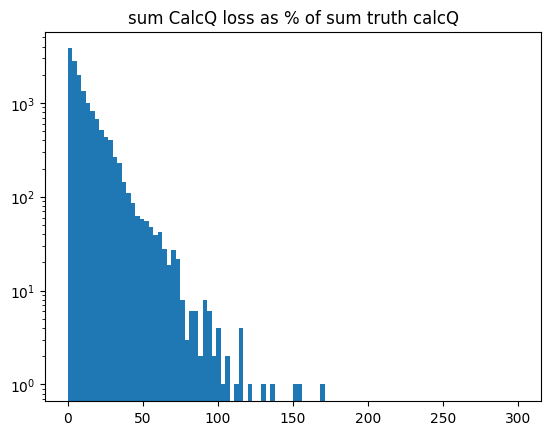

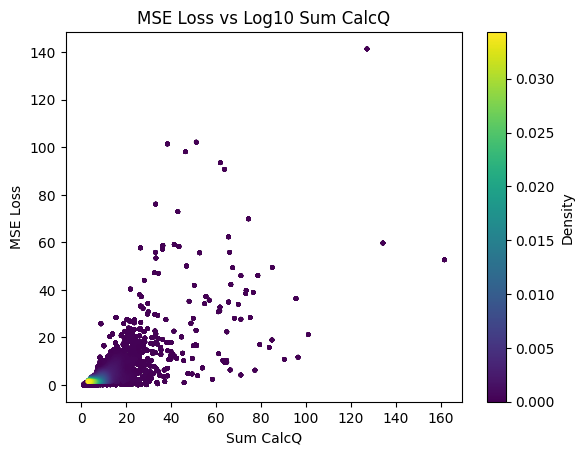

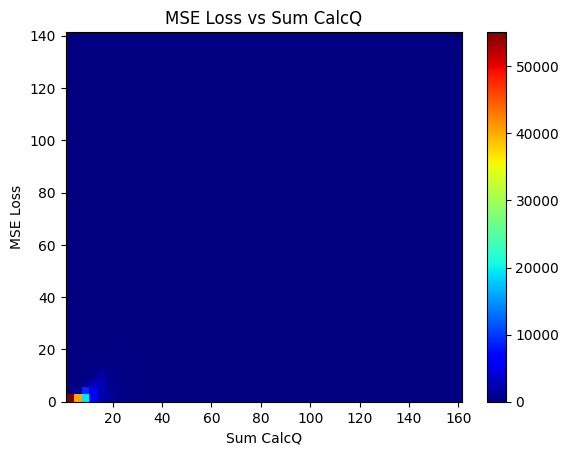

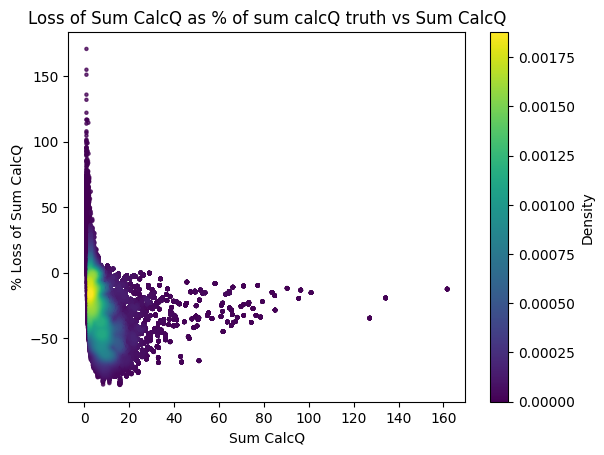

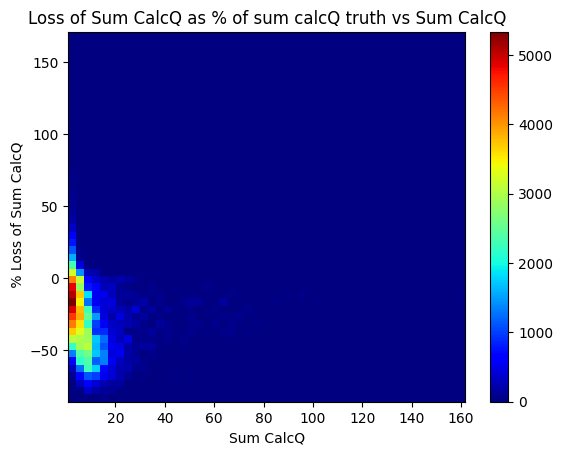

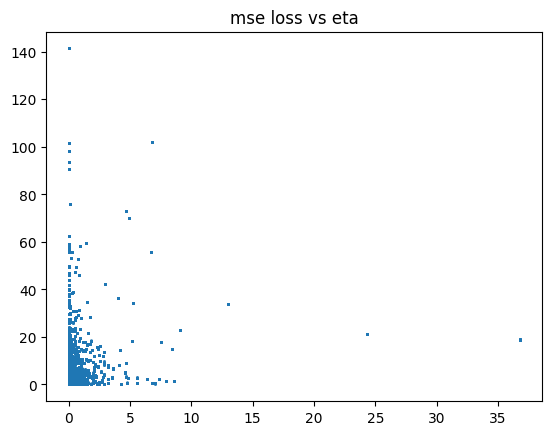

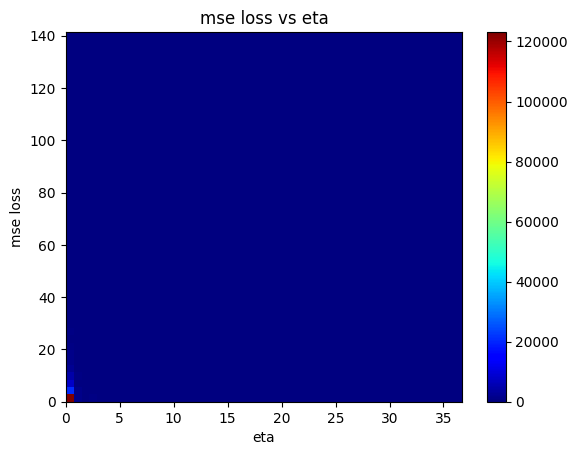

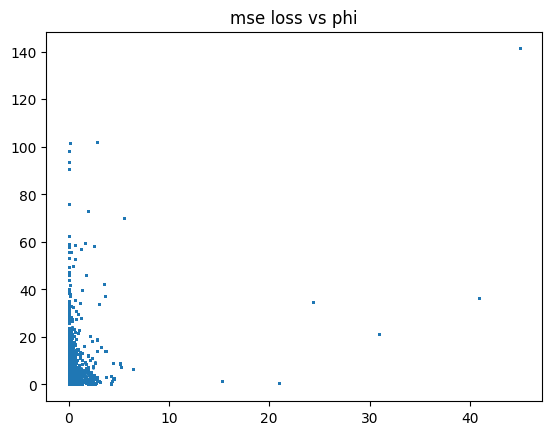

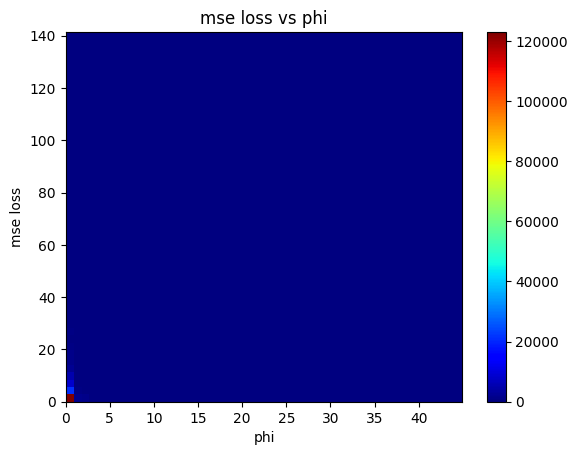

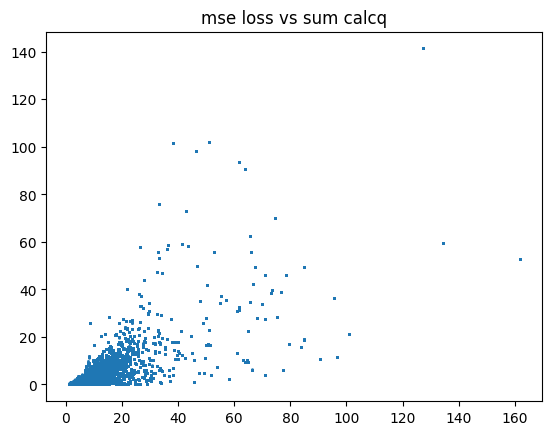

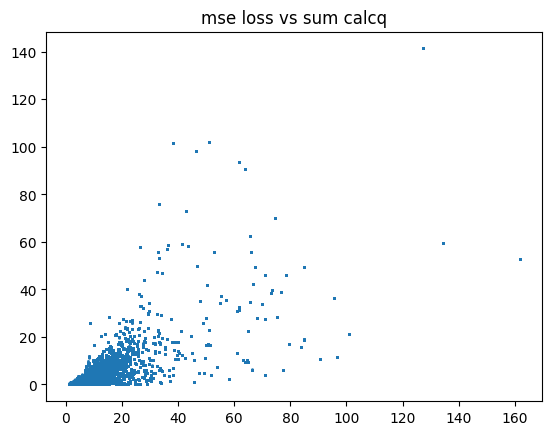

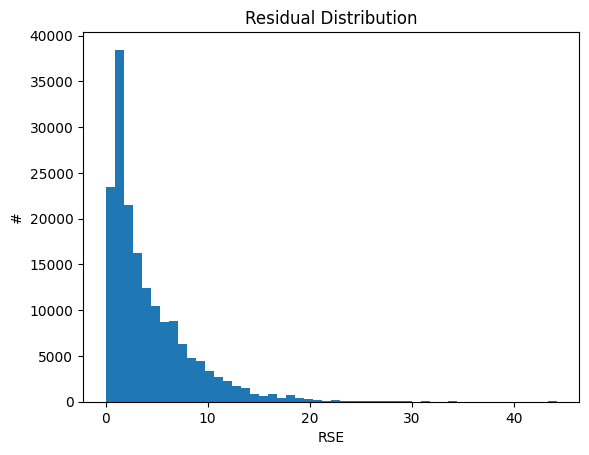

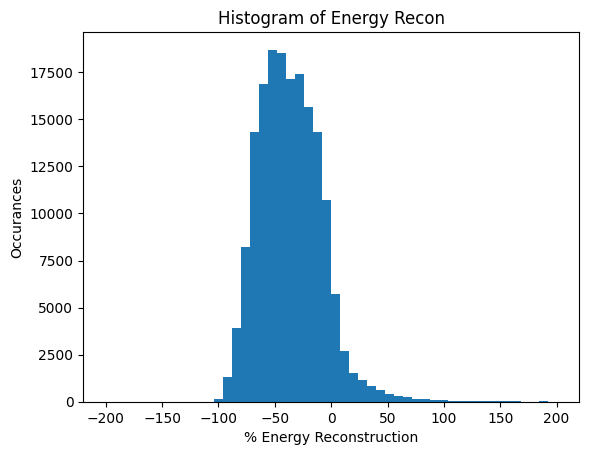

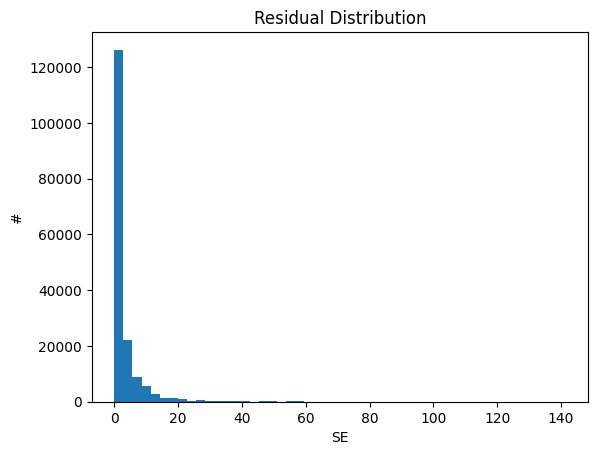

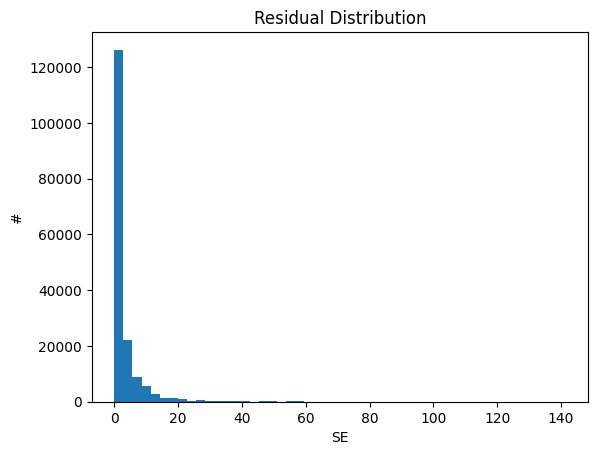

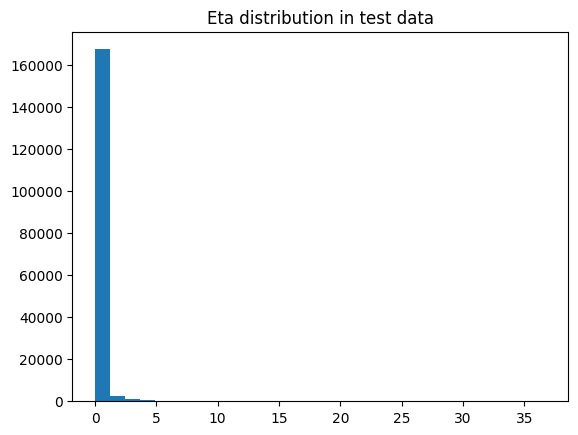

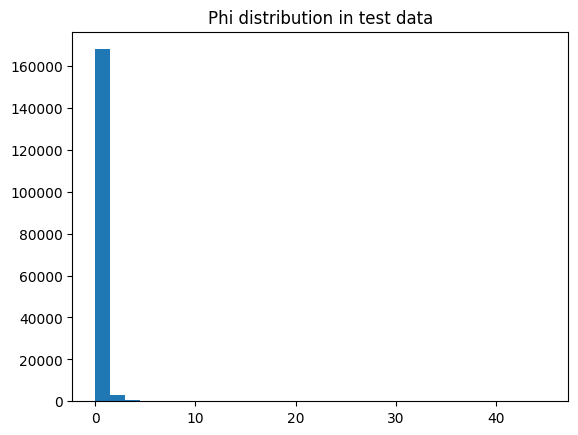

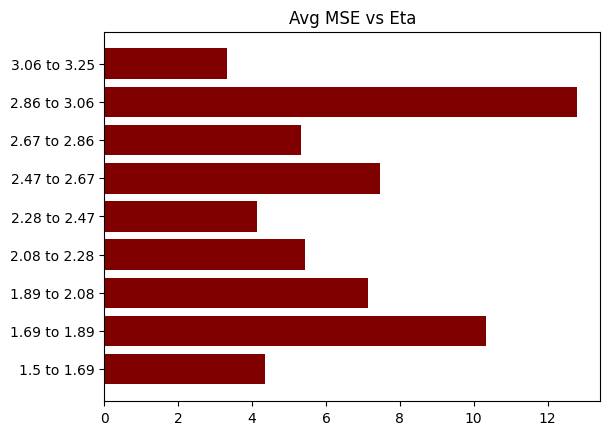

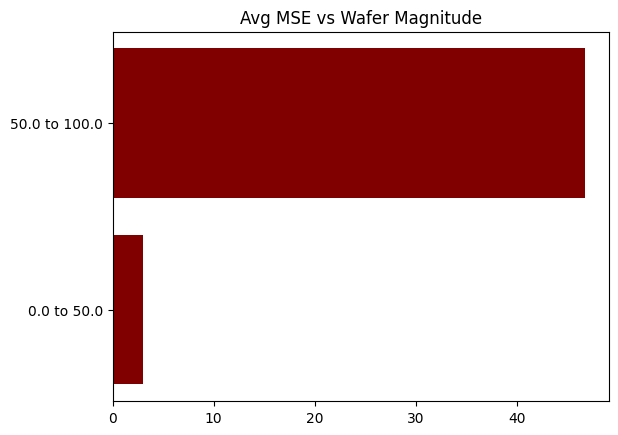

tensor([[0.0000e+00, 1.6814e+00, 1.5713e+01, 6.7580e+00, 1.0496e+01],
        [2.0356e+00, 1.9284e+00, 2.5772e+01, 1.2156e+01, 1.3099e+01],
        [0.0000e+00, 0.0000e+00, 1.3177e+01, 4.2876e+00, 8.3571e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 2.0568e+00, 2.7618e-01, 1.6187e+00],
        [0.0000e+00, 2.5023e-02, 1.4966e+00, 6.6225e-02, 7.1945e-01],
        [0.0000e+00, 0.0000e+00, 1.9234e+00, 1.9870e-01, 9.6105e-01]],
       grad_fn=<CatBackward0>)

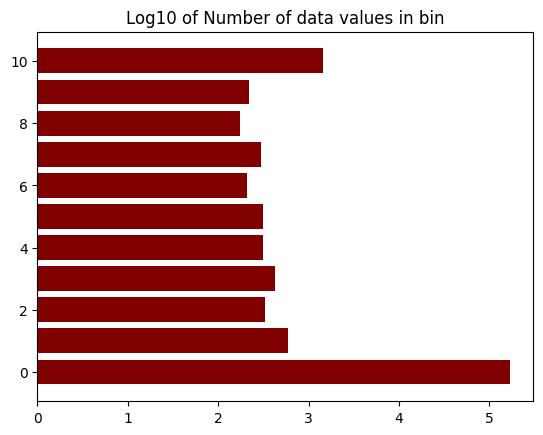

In [19]:
AE_Stats.gen_all_stats(test_pred.cpu(),data_1_test.cpu(),data_1_test.cpu())


In [1]:


import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()



Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 72% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  3% | 74% |


In [11]:
class CVAE(nn.Module):

    def __init__(self,layers,latent_dims = 16, with_loc=False,device = 'cuda'):
        """Initialize the DAE

        Parameters
        ----------
        layers: list[int]
            the number of dimensions in each layer of the DAE

        """
        
        super(CVAE, self).__init__()
        encoders = []
        decoders = []

        prev_layer = layers[0]
        i = 0
        for layer in layers[1:]:
            
            encoders.append(
                nn.Linear(in_features=prev_layer, out_features=layer))
            encoders.append(
                nn.ReLU())
            if i == len(layers)-2:
                decoders.append(
                    nn.Linear(in_features=17, out_features=prev_layer))
            else:
                 decoders.append(
                    nn.Linear(in_features=layer, out_features=prev_layer))
            decoders.append(
                nn.ReLU())
            i = i +1
            prev_layer = layer
        
        #Encoders pre conditioning
        self.encoders = nn.ModuleList(encoders)
        self.decoders = nn.ModuleList(reversed(decoders))
        self.decoders = nn.ModuleList(reversed([nn.ReLU()]+decoders))
        
        
        #post conditioning
        self.linear_enc = nn.Linear(layers[-1]+1,layers[-1])
        self.linear_mean = nn.Linear(layers[-1],latent_dims)
        self.linear_sig = nn.Linear(layers[-1],latent_dims)
        
        self.N       = torch.distributions.Normal(0, 1)
        self.N.loc   = self.N.loc 
        self.N.scale = self.N.scale
        self.kl = 0
        
        self.decoder_latent = nn.Sequential(
            nn.Linear(latent_dims+1, layers[-1]),
            nn.ReLU(True)
        )
        self.device = device
        
    def forward(self, x,c):
        """Forward step
        
        Parameters
        ----------
        x: Tensor
            input tensor
        
        Returns
        -------
        Tensor
            a reconstructed version of x

        """
        x_encoded = self.encode(x,c)
        x_reconstructed = self.decode(x_encoded,c)
        return x_reconstructed

    def encode(self, x,c):
        """Encode the input x
        
        Parameters
        ----------
        x: Tensor
            input to encode
        x: Tensor
            conditional data
        
        Returns
        -------
        Tensor
            encoded input

        """
        
        for i, enc in enumerate(self.encoders):
            if i == len(self.encoders) - 1:
                x = enc(x)
            else:
                x = enc(x)

        
        mu =  self.linear_mean(x) #Mean in the gaussian space
        sigma = torch.exp(self.linear_sig(x)) #sigma in the space
        z = mu + sigma*self.N.sample(mu.shape).to(self.device) #smear 
        self.kl = torch.sum((sigma**2 + mu**2 - torch.log(sigma) - 1/2),dim=1)
        return z
    
    def decode(self, x,c):
        """Decode the representation x
        
        Parameters
        ----------
        x: Tensor
            input to decode
        
        Returns
        -------
        Tensor
            decoded input

        """
        x = torch.hstack([x,c])
        for dec in self.decoders:
            x = dec(x)
        return x

In [7]:
data_path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/MIT_TTbar'
all_files = os.listdir(data_path)
dt_files = []
for f in all_files:
    if f[0:7] == 'dt_norm' and (f[-3:] != 'low' and f[-4:] !='high'):
        dt_files.append(f)
      

In [8]:
dt_files.sort()

In [9]:
dt_files[20]

'dt_norm_2_11'

In [10]:
losses = []
for d in dt_files:
    dt_cur = torch.load(os.path.join(data_path,d)).to('cpu')
    mod = torch.load(os.path.join('models/batched_models/CVAE_new_loss_250_150_low_high',d)).to('cpu')
    mod.device = 'cpu'
    sum_TC = torch.unsqueeze(torch.sum(dt_cur[-int(len(dt_cur)*0.2):,0:48],dim=1).to('cpu'),dim=1)
    losses.append(new_loss(dt_cur[-int(len(dt_cur)*0.2):,0:48],mod(dt_cur[-int(len(dt_cur)*0.2):,0:48],sum_TC),2,0,1).item())

In [11]:
losses

[0.5666989684104919,
 3.7725162506103516,
 4.559578895568848,
 3.3947999477386475,
 7.675964832305908,
 5.692455768585205,
 5.684399604797363,
 4.0338239669799805,
 3.8667924404144287,
 2.0706541538238525,
 1.1343990564346313,
 5.078864097595215,
 1.1185225248336792,
 1.276913046836853,
 0.9729400277137756,
 0.748235285282135,
 6.5541157722473145,
 6.23519229888916,
 5.0432939529418945,
 4.452099323272705,
 7.6971540451049805,
 7.207724571228027,
 4.126353740692139,
 3.2779438495635986,
 3.951733350753784,
 2.5763497352600098,
 2.109576463699341,
 1.7523187398910522,
 1.2148042917251587,
 0.6429328322410583,
 10.509751319885254,
 0.9887844920158386,
 0.46642419695854187,
 0.428363561630249,
 0.5513017177581787,
 0.4750403165817261,
 0.4683683216571808,
 0.5711027383804321,
 0.19089087843894958,
 0.20751352608203888,
 0.1887967586517334,
 0.12337686866521835,
 0.18515287339687347,
 0.0992618128657341,
 0.1696767956018448,
 0.22242338955402374,
 14.437345504760742,
 13.529431343078613,
 

In [71]:
losses[62]

36.92322540283203

In [70]:
dt_files[62]

'dt_norm_3_5'

In [74]:
import train_cvae
# from Naive_DAE import CVAE
device = 'cuda'

In [ ]:
importlib.reload(train_cvae)
train_cvae.retrain_CVAEs(data_path,
              dt_files,
              losses,
              model_params = 'retrain',
              override = False,
              loss_threshold =5,
              loss = combo_loss, 
              path_1_low = 'models/CVAE_Models/dt_1_250_150_low',
              path_2_low = 'models/CVAE_Models/dt_2_250_150_low',
              path_3_low = 'models/CVAE_Models/dt_3_250_150_low',
              path_1_high = 'models/CVAE_Models/dt_1_250_150_low',
              path_2_high = 'models/CVAE_Models/dt_2_250_150_low',
              path_3_high = 'models/CVAE_Models/dt_3_250_150_low',
             dir_label ='CVAE_new_loss_250_150_low_high',
             epochs= 301,
             batch = 100, 
             max_dt_size = 200000,
             lr = 4.5e-8)

5.172723770141602
6.554124355316162
6.235189437866211
5.043567180633545
7.675738334655762
5.691682815551758
5.684284687042236
10.50946044921875
14.43717098236084
13.529257774353027
9.643375396728516
7.697169780731201
7.207488536834717
16.128429412841797
17.53912925720215
36.079002380371094
21.357282638549805
17.450904846191406
9.315013885498047
11.40659236907959
8.459663391113281
TRAINING MODEL dt_norm_1_3
cur loss = 5.172723770141602
TRAINING INFO:
Total Dataset Size: 200000
Epoch 0, lr 4.5e-08
Epoch 0: Train 5.245, Test 5.112
MSE NON-NORMALIZED: Train MSE 34.459, Test MSE 30.019
Epoch 5, lr 4.5e-08
Epoch 5: Train 5.209, Test 5.092
MSE NON-NORMALIZED: Train MSE 34.312, Test MSE 29.939
Epoch 10, lr 4.5e-08
Epoch 10: Train 5.205, Test 5.088
MSE NON-NORMALIZED: Train MSE 34.340, Test MSE 29.923
Epoch 15, lr 4.5e-08
Epoch 15: Train 5.203, Test 5.087
MSE NON-NORMALIZED: Train MSE 34.326, Test MSE 29.916
Epoch 20, lr 4.5e-08
Epoch 20: Train 5.202, Test 5.086
MSE NON-NORMALIZED: Train MSE 34

Epoch 35, lr 2.25e-08
Epoch 35: Train 6.575, Test 6.405
MSE NON-NORMALIZED: Train MSE 32.354, Test MSE 36.029
Epoch 40, lr 1.125e-08
Epoch 40: Train 6.575, Test 6.405
MSE NON-NORMALIZED: Train MSE 32.359, Test MSE 36.031
Epoch 45, lr 1.125e-08
Epoch 45: Train 6.575, Test 6.404
MSE NON-NORMALIZED: Train MSE 32.416, Test MSE 36.028
Epoch 50, lr 1.125e-08
Epoch 50: Train 6.575, Test 6.404
MSE NON-NORMALIZED: Train MSE 32.362, Test MSE 36.028
Epoch 55, lr 1.125e-08
Epoch 55: Train 6.575, Test 6.404
MSE NON-NORMALIZED: Train MSE 32.339, Test MSE 36.029
Epoch 60, lr 1.125e-08
Epoch 60: Train 6.575, Test 6.404
MSE NON-NORMALIZED: Train MSE 32.305, Test MSE 36.028
Epoch 65, lr 1.125e-08
Epoch 65: Train 6.574, Test 6.404
MSE NON-NORMALIZED: Train MSE 32.325, Test MSE 36.027
Epoch 70, lr 1.125e-08
Epoch 70: Train 6.574, Test 6.404
MSE NON-NORMALIZED: Train MSE 32.357, Test MSE 36.024
Epoch 75, lr 1.125e-08
Epoch 75: Train 6.574, Test 6.404
MSE NON-NORMALIZED: Train MSE 32.364, Test MSE 36.025
Ep

In [41]:
importlib.reload(train_cvae)
train_cvae.retrain_CVAEs(data_path,
              dt_files,
              model_params = [],
              override = False,
              loss = new_loss, 
              path_1_low = 'models/CVAE_Models/dt_1_250_150_low',
              path_2_low = 'models/CVAE_Models/dt_2_250_150_low',
              path_3_low = 'models/CVAE_Models/dt_3_250_150_low',
              path_1_high = 'models/CVAE_Models/dt_1_250_150_high',
              path_2_high = 'models/CVAE_Models/dt_2_250_150_high',
              path_3_high = 'models/CVAE_Models/dt_3_250_150_high',
             dir_label ='CVAE_new_loss_250_150_low_high',
             epochs= 251,
             batch = 300, 
             max_dt_size = 50000,
             lr = 3.5e-5)

TypeError: retrain_CVAEs() missing 1 required positional argument: 'losses'

In [4]:
import CAE_generate_stats

In [6]:
import CAE_generate_stats
importlib.reload(CAE_generate_stats)

CAE_generate_stats.gen_batch_stats("models/batched_models/CVAE_new_loss_250_150_low_high",
                                  data_path
                                  )

NameError: name 'data_path' is not defined